In [247]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [248]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [249]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [250]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [251]:
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.zip') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.zip') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [252]:
print(df_train.shape[0], df_test.shape[0] == sample_submission.shape[0])
for i, v in enumerate(df_train.columns):
    if df_train[v].dtype == 'object':
        print(i, v, df_train[v].nunique(), round(df_train[v].nunique() / df_train.shape[0] * 100, 2))

386803 True
0 hotel_address 1493 0.39
2 review_date 731 0.19
4 hotel_name 1492 0.39
5 reviewer_nationality 225 0.06
6 negative_review 248828 64.33
9 positive_review 311737 80.59
13 tags 47135 12.19
14 days_since_review 731 0.19


In [253]:
#df_train.groupby(by='negative_review', as_index=False)['hotel_address'].count().sort_values(by='hotel_address', ascending=False).head(50)
df_train.groupby(by='positive_review', as_index=False)['hotel_address'].count().sort_values(by='hotel_address', ascending=False).head(50)

,positive_review,hotel_address
311736,No Positive,26885
117957,Location,6833
43203,Everything,1697
297218,location,1251
154852,Nothing,931
218412,The location,830
83504,Great location,809
73030,Good location,690
117958,Location,663
19513,Breakfast,455


In [254]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [255]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [256]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [257]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [258]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [259]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [260]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\admin\AppData\Local\Temp\ipykernel_15324\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [262]:
where1 = data['lat'].isnull()
where2 = data.lat 

data21 = data[data.lat.isnull() & data.lng.isnull()]
data22 = data[data.lat.isnull()]
data23 = data[data.lng.isnull()]
data24 = data[data.lat.isnull() & data.lng.isnull()][['hotel_name', 'hotel_address']]
print(data21.shape, data22.shape, data23.shape, data24.shape)
print(data24['hotel_name'].unique().shape)

# filter_name = ['hotel_address'].iloc[0]
# print(filter_name)
print(data24)

where3 = (data['hotel_address'] == filter_name)
data2 = data[where3]
data.shape, data2.shape

(3268, 18) (3268, 18) (3268, 18) (3268, 2)
(17,)
                                    hotel_name  \
35                               Hotel Atlanta   
293                              Hotel Atlanta   
476                  City Hotel Deutschmeister   
526               Holiday Inn Paris Montmartre   
569        Fleming s Selection Hotel Wien City   
...                                        ...   
515027                      Hotel City Central   
515400                      Hotel City Central   
515439  Maison Albar Hotel Paris Op ra Diamond   
515637                      Hotel City Central   
515699                           Hotel Atlanta   

                                            hotel_address  
35      W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  
293     W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  
476     Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  
526          23 Rue Damr mont 18th arr 75018 Paris France  
569     Josefst dter Stra e 10 12 08 Josefstadt 10

((515738, 18), (389, 18))

In [263]:
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
reviewer_nationality = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, reviewer_nationality], axis=1)

In [264]:
bin_encoder = ce.BinaryEncoder(cols=['days_since_review']) # указываем столбец для кодирования
days_since_review = bin_encoder.fit_transform(data['days_since_review'])
data = pd.concat([data, days_since_review], axis=1)

In [265]:
# bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
# hotel_name = bin_encoder.fit_transform(data['hotel_name'])
# data = pd.concat([data, hotel_name], axis=1)

# bin_encoder = ce.BinaryEncoder(cols=['hotel_address']) # указываем столбец для кодирования
# hotel_address = bin_encoder.fit_transform(data['hotel_address'])
# data = pd.concat([data, hotel_address], axis=1)

In [266]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

In [267]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                                1
lng                                                1
sample                                             2
reviewer_score                                    38
reviewer_nationality_0                        

C:\Users\admin\AppData\Local\Temp\ipykernel_15324\1624597386.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)


<AxesSubplot: >

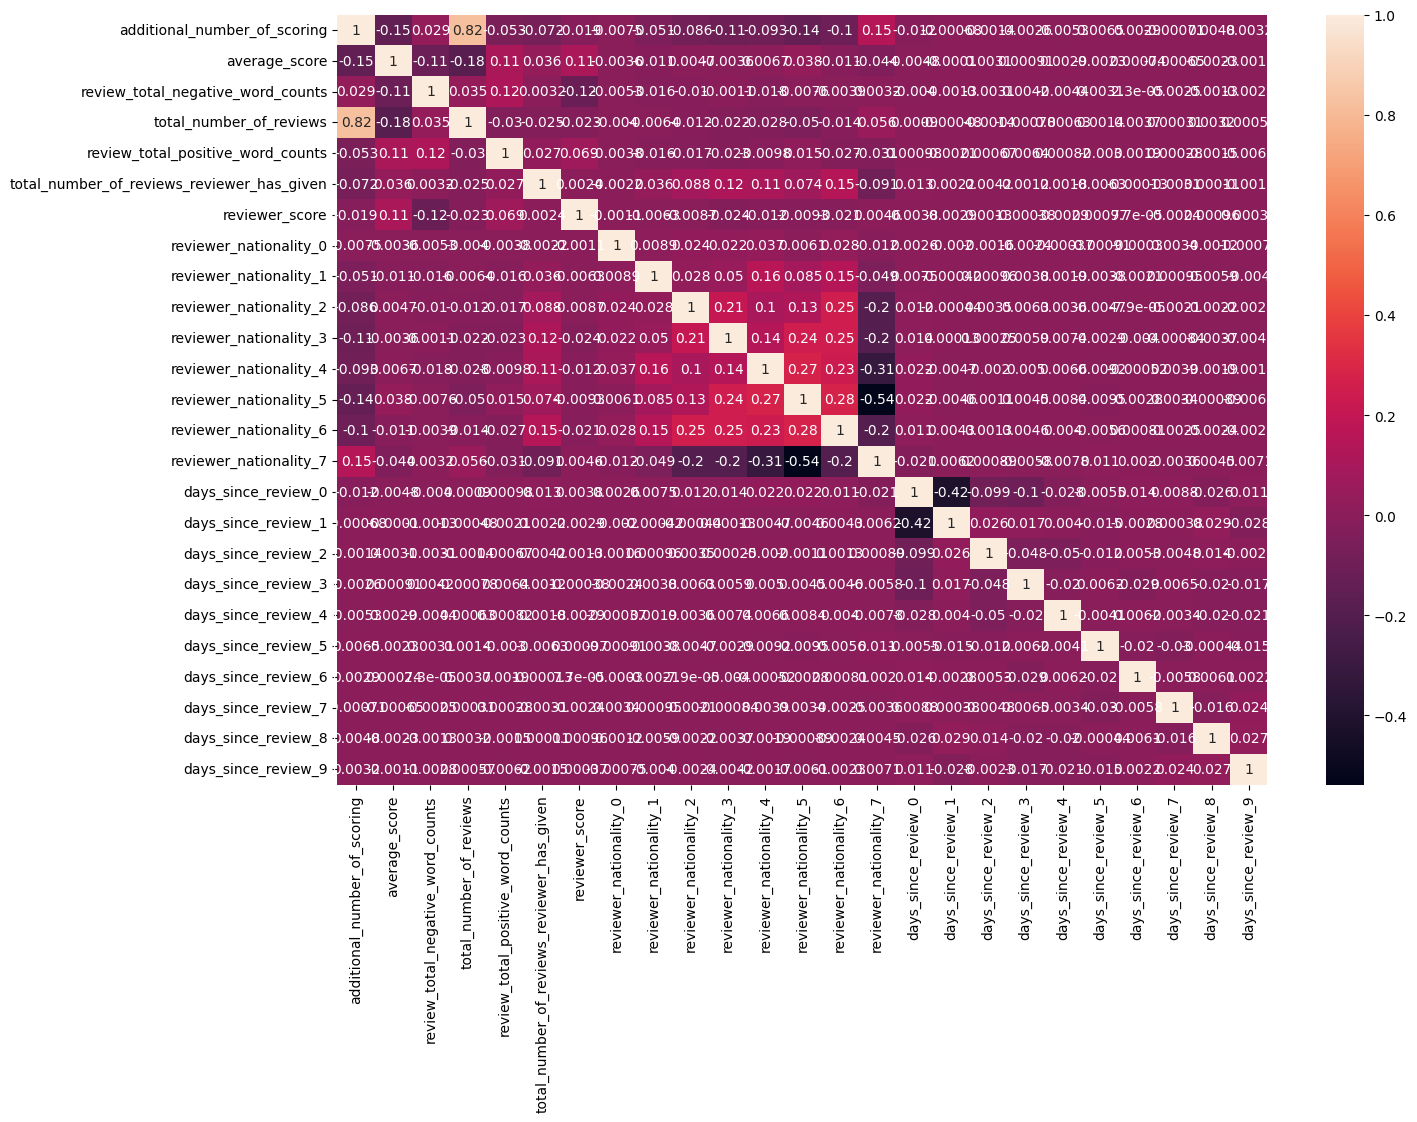

In [268]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [269]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   reviewer_nationality_0                      515738 non-null  int64  
 9   reviewer_nationality_1                      515738 non-null  int64  
 

In [271]:
print(data.shape)
print(data.query('sample == 0').shape)
print(data.query('sample == 1').shape)

(515738, 26)
(128935, 26)
(386803, 26)


In [272]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [273]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [274]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386803, 25), (386803, 24), (309442, 24), (77361, 24))

In [275]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [276]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [277]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [278]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9480931653454026


<AxesSubplot: >

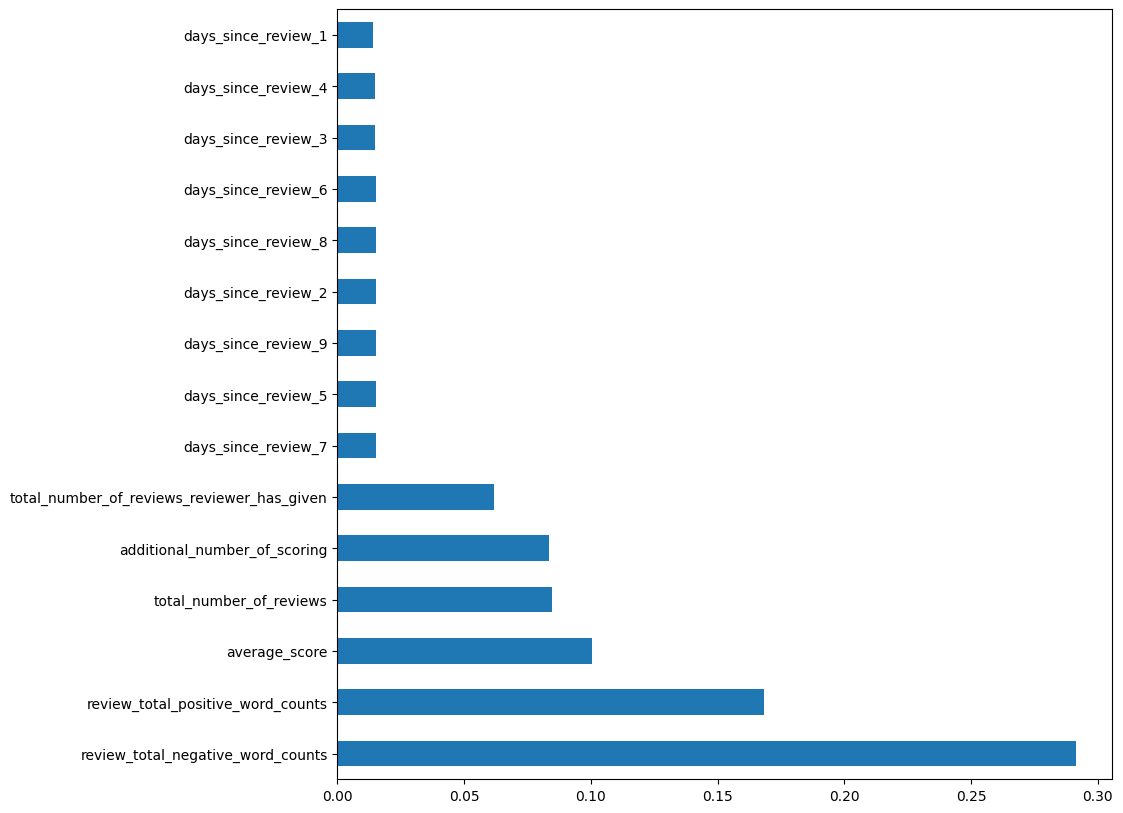

In [279]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [280]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,...,days_since_review_0,days_since_review_1,days_since_review_2,days_since_review_3,days_since_review_4,days_since_review_5,days_since_review_6,days_since_review_7,days_since_review_8,days_since_review_9
44090,333,8.0,0,2611,16,1,0.0,0,0,0,...,0,0,1,1,1,0,1,1,0,0
42965,387,8.9,7,2695,58,5,0.0,0,0,0,...,1,0,1,0,0,1,0,0,1,1
42932,1831,8.1,32,7105,26,1,0.0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
14121,114,8.3,19,1093,3,1,0.0,0,1,0,...,0,1,0,0,1,1,1,1,0,0
71278,2288,8.1,14,9568,76,1,0.0,0,0,0,...,0,0,0,1,1,1,0,1,0,1
66377,804,9.1,15,3802,8,1,0.0,0,0,0,...,1,0,0,1,1,1,1,1,1,1
7929,294,8.7,0,1271,38,10,0.0,0,0,0,...,0,1,0,0,1,1,1,1,1,1
75173,764,8.2,32,2996,23,23,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
52283,409,8.3,43,1592,38,24,0.0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
56242,44,9.0,0,253,9,1,0.0,0,0,0,...,0,1,0,1,1,0,0,0,1,0


In [281]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [282]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [283]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


In [284]:
predict_submission

array([8.304, 7.68 , 8.057, ..., 8.634, 9.502, 7.191])

In [285]:
list(sample_submission)

['reviewer_score', 'id']

In [286]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.304,488440
1,7.680,274649
2,8.057,374688
3,9.594,404352
4,9.616,451596
5,8.790,302161
6,8.226,317079
7,7.673,13963
8,8.655,159785
9,7.970,195089
